In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

#loading the data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoxg/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoxg/test.csv')

<ipython-input-1-00cf69c599c3>:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoxg/train.csv')


In [2]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [3]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''

    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}'])
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}'])
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [4]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [5]:
def convert_to_long_form(df, feature_columns, history_columns):
    '''coverting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [6]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams,
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')

        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')

    return df


In [7]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [8]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''

    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']

    home_team_history_goal_info_available=df.groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_history_goal_info_available.to_frame(name='home_team_history_goal_info_available'), on='id')
    away_team_history_goal_info_available=df.groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_history_goal_info_available.to_frame(name='away_team_history_goal_info_available'), on='id')
    home_team_history_rating_info_available=df.groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_history_rating_info_available.to_frame(name='home_team_history_rating_info_available'), on='id')
    away_team_history_rating_info_available=df.groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_history_rating_info_available.to_frame(name='away_team_history_rating_info_available'), on='id')


    for i in [5,10]:
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(name=f'home_team_history_average_goal_conceded_{i}'), on='id')

        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'), on='id')

        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']

        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')

        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')

    home_team_home_form_average_goal_scored=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal.mean()
    df=df.join(home_team_home_form_average_goal_scored.to_frame(name='home_team_home_form_average_goal_scored'), on='id')
    home_team_home_form_average_goal_conceded=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_opponent_goal.mean()
    df=df.join(home_team_home_form_average_goal_conceded.to_frame(name='home_team_home_form_average_goal_conceded'), on='id')
    home_team_home_form_average_goal_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.mean()
    df=df.join(home_team_home_form_average_goal_difference.to_frame(name='home_team_home_form_average_goal_difference'), on='id')
    home_team_home_form_goal_difference_std=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.std()
    df=df.join(home_team_home_form_goal_difference_std.to_frame(name='home_team_home_form_goal_difference_std'), on='id')
    home_team_home_form_win_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==3)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_win_rate.to_frame(name='home_team_home_form_win_rate'), on='id')
    home_team_home_form_draw_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==1)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_draw_rate.to_frame(name='home_team_home_form_draw_rate'), on='id')
    home_team_home_form_lose_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==0)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_lose_rate.to_frame(name='home_team_home_form_lose_rate'), on='id')
    home_team_home_form_average_point=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_point.mean()
    df=df.join(home_team_home_form_average_point.to_frame(name='home_team_home_form_average_point'), on='id')
    home_team_home_form_median_rating_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.median()
    df=df.join(home_team_home_form_median_rating_difference.to_frame(name='home_team_home_form_median_rating_difference'), on='id')
    home_team_home_form_goal_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_home_form_goal_info_available.to_frame(name='home_team_home_form_goal_info_available'), on='id')
    home_team_home_form_rating_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_home_form_rating_info_available.to_frame(name='home_team_home_form_rating_info_available'), on='id')

    away_team_away_form_average_goal_scored=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal.mean()
    df=df.join(away_team_away_form_average_goal_scored.to_frame(name='away_team_away_form_average_goal_scored'), on='id')
    away_team_away_form_average_goal_conceded=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_opponent_goal.mean()
    df=df.join(away_team_away_form_average_goal_conceded.to_frame(name='away_team_away_form_average_goal_conceded'), on='id')
    away_team_away_form_average_goal_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.mean()
    df=df.join(away_team_away_form_average_goal_difference.to_frame(name='away_team_away_form_average_goal_difference'), on='id')
    away_team_away_form_goal_difference_std=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.std()
    df=df.join(away_team_away_form_goal_difference_std.to_frame(name='away_team_away_form_goal_difference_std'), on='id')
    away_team_away_form_win_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==3)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_win_rate.to_frame(name='away_team_away_form_win_rate'), on='id')
    away_team_away_form_draw_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==1)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_draw_rate.to_frame(name='away_team_away_form_draw_rate'), on='id')
    away_team_away_form_lose_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==0)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_lose_rate.to_frame(name='away_team_away_form_lose_rate'), on='id')
    away_team_away_form_average_point=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_point.mean()
    df=df.join(away_team_away_form_average_point.to_frame(name='away_team_away_form_average_point'), on='id')
    away_team_away_form_median_rating_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.median()
    df=df.join(away_team_away_form_median_rating_difference.to_frame(name='away_team_away_form_median_rating_difference'), on='id')
    away_team_away_form_goal_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_away_form_goal_info_available.to_frame(name='away_team_away_form_goal_info_available'), on='id')
    away_team_away_form_rating_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_away_form_rating_info_available.to_frame(name='away_team_away_form_rating_info_available'), on='id')

    return df

In [9]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals based on this'''

    home_history_columns=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id']
    home_history=df[home_history_columns]
    home_history=home_history.drop_duplicates()

    away_history_columns=['away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    away_history=df[away_history_columns]
    away_history=away_history.drop_duplicates()

    league_total_goal = home_history.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = home_history.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal=df.league_average_goal.fillna(df.league_average_goal.mean())

    league_total_home_goal = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    df.league_average_home_goal=df.league_average_home_goal.fillna(df.league_average_home_goal.mean())

    league_total_away_goal = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    df.league_average_away_goal=df.league_average_away_goal.fillna(df.league_average_away_goal.mean())

    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength


    #getting teams' record of goal scored and conceded in each league
    home_team_league_average_goal_scored=df.groupby(['id','home_team_history_league_id']).home_team_history_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_scored.columns=['id','league_id','home_team_league_average_goal_scored']
    df=pd.merge(df, home_team_league_average_goal_scored, how='left')

    home_team_league_average_goal_conceded=df.groupby(['id','home_team_history_league_id']).home_team_history_opponent_goal.agg(['mean']).reset_index()
    home_team_league_average_goal_conceded.columns=['id','league_id','home_team_league_average_goal_conceded']
    df=pd.merge(df, home_team_league_average_goal_conceded, how='left')

    away_team_league_average_goal_scored=df.groupby(['id','away_team_history_league_id']).away_team_history_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_scored.columns=['id','league_id','away_team_league_average_goal_scored']
    df=pd.merge(df, away_team_league_average_goal_scored, how='left')

    away_team_league_average_goal_conceded=df.groupby(['id','away_team_history_league_id']).away_team_history_opponent_goal.agg(['mean']).reset_index()
    away_team_league_average_goal_conceded.columns=['id','league_id','away_team_league_average_goal_conceded']
    df=pd.merge(df, away_team_league_average_goal_conceded, how='left')

    #setting another set of attack, defense and expected goal data based on team's record
    df['home_team_league_attack_strength'] = df.home_team_league_average_goal_scored/df.league_average_goal
    df['home_team_league_defense_strength'] = df.home_team_league_average_goal_conceded/df.league_average_goal
    df['away_team_league_attack_strength'] = df.away_team_league_average_goal_scored/df.league_average_goal
    df['away_team_league_defense_strength'] = df.away_team_league_average_goal_conceded/df.league_average_goal
    df['home_team_league_expected_goal'] = df.league_average_home_goal*df.home_team_league_attack_strength*df.away_team_league_defense_strength
    df['away_team_league_expected_goal'] = df.league_average_away_goal*df.away_team_league_attack_strength*df.home_team_league_defense_strength

    #getting coach's record of goal scored and conceded in each league
    home_coach_goal=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_goal']].dropna()
    home_coach_goal=home_coach_goal.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_goal2=home_coach_goal.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_goal2['home_team_coach_league_average_goal_scored']=(home_coach_goal2['cumsum'])/(home_coach_goal2['cumcount']+1)
    home_coach_goal3=home_coach_goal2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_scored']]
    home_coach_goal3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_scored']
    home_coach_goal3=home_coach_goal3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_goal3, how='left')

    home_coach_conceded=df.drop_duplicates(subset=home_history_columns)[['home_team_history_coach','home_team_history_league_id', \
                                                             'home_team_history_match_date','home_team_history_opponent_goal']].dropna()
    home_coach_conceded=home_coach_conceded.sort_values(by=['home_team_history_coach','home_team_history_league_id','home_team_history_match_date'],\
                                                ascending=[True,True,True])
    home_coach_conceded2=home_coach_conceded.set_index(['home_team_history_coach','home_team_history_league_id','home_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).home_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    home_coach_conceded2['home_team_coach_league_average_goal_conceded']=(home_coach_conceded2['cumsum'])/(home_coach_conceded2['cumcount']+1)
    home_coach_conceded3=home_coach_conceded2[['home_team_history_coach','home_team_history_league_id',\
                                       'home_team_history_match_date','home_team_coach_league_average_goal_conceded']]
    home_coach_conceded3.columns=['home_team_coach_id','league_id','home_team_history_match_date','home_team_coach_league_average_goal_conceded']
    home_coach_conceded3=home_coach_conceded3.drop_duplicates(subset=['home_team_coach_id','league_id','home_team_history_match_date'])
    df=df.merge(home_coach_conceded3, how='left')

    away_coach_goal=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_goal']].dropna()
    away_coach_goal=away_coach_goal.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_goal2=away_coach_goal.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_goal2['away_team_coach_league_average_goal_scored']=(away_coach_goal2['cumsum'])/(away_coach_goal2['cumcount']+1)
    away_coach_goal3=away_coach_goal2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_scored']]
    away_coach_goal3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_scored']
    away_coach_goal3=away_coach_goal3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_goal3, how='left')

    away_coach_conceded=df.drop_duplicates(subset=away_history_columns)[['away_team_history_coach','away_team_history_league_id', \
                                                             'away_team_history_match_date','away_team_history_opponent_goal']].dropna()
    away_coach_conceded=away_coach_conceded.sort_values(by=['away_team_history_coach','away_team_history_league_id','away_team_history_match_date'],\
                                                ascending=[True,True,True])
    away_coach_conceded2=away_coach_conceded.set_index(['away_team_history_coach','away_team_history_league_id','away_team_history_match_date']\
                                             ).groupby(level=1, as_index=False).away_team_history_opponent_goal.agg(['cumsum','cumcount']).reset_index()
    away_coach_conceded2['away_team_coach_league_average_goal_conceded']=(away_coach_conceded2['cumsum'])/(away_coach_conceded2['cumcount']+1)
    away_coach_conceded3=away_coach_conceded2[['away_team_history_coach','away_team_history_league_id',\
                                       'away_team_history_match_date','away_team_coach_league_average_goal_conceded']]
    away_coach_conceded3.columns=['away_team_coach_id','league_id','away_team_history_match_date','away_team_coach_league_average_goal_conceded']
    away_coach_conceded3=away_coach_conceded3.drop_duplicates(subset=['away_team_coach_id','league_id','away_team_history_match_date'])
    df=df.merge(away_coach_conceded3, how='left')

    #setting another set of attack, defense and expected goal data based on coach's record
    df['home_team_coach_attack_strength'] = df.home_team_coach_league_average_goal_scored/df.league_average_goal
    df['home_team_coach_defense_strength'] = df.home_team_coach_league_average_goal_conceded/df.league_average_goal
    df['away_team_coach_attack_strength'] = df.away_team_coach_league_average_goal_scored/df.league_average_goal
    df['away_team_coach_defense_strength'] = df.away_team_coach_league_average_goal_conceded/df.league_average_goal
    df['home_team_coach_expected_goal'] = df.league_average_home_goal*df.home_team_coach_attack_strength*df.away_team_coach_defense_strength
    df['away_team_coach_expected_goal'] = df.league_average_away_goal*df.away_team_coach_attack_strength*df.home_team_coach_defense_strength

    return df

In [10]:
def reshape(df):
    '''reshape the dataframe back to wide form'''
    history_columns=['home_team_history_is_play_home',
              'home_team_history_is_cup',
              'home_team_history_goal',
              'home_team_history_opponent_goal',
              'home_team_history_rating',
              'home_team_history_opponent_rating',
              'home_team_history_coach',
              'home_team_history_league_id',
              'home_team_history_goal_difference',
              'home_team_history_point',
              'home_team_history_rating_difference',
              'away_team_history_is_play_home',
              'away_team_history_is_cup',
              'away_team_history_goal',
              'away_team_history_opponent_goal',
              'away_team_history_rating',
              'away_team_history_opponent_rating',
              'away_team_history_coach',
              'away_team_history_league_id',
              'away_team_history_goal_difference',
              'away_team_history_point',
              'away_team_history_rating_difference']
    drop_columns=['match','match_date','home_team_history_match_date','away_team_history_match_date']
    df_history=df[history_columns+['id','match']].set_index(['id','match']).unstack(level=1)
    df_history.columns = df_history.columns.map('{0[0]}_{0[1]}'.format)
    df_history=df_history.reset_index()
    df_new=df.groupby('id').first().reset_index().drop(history_columns+drop_columns, axis=1)
    df_new=df_new.merge(df_history, how='left')

    return df_new


In [11]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df=reshape(df)

    return df

In [12]:
train_p=preprocession(train)

In [13]:
train_p

,id,away_has_coach_change,is_cup,home_team_coach_id,league_id,away_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,11428294,0,0.0,468693.0,755,257433.0,1,6.083333,5.083333,6.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,11428295,0,0.0,37331516.0,755,16476269.0,1,4.000000,4.083333,4.000000,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,11428297,0,0.0,212710.0,755,474745.0,1,3.916667,6.000000,3.916667,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,11428298,0,0.0,186127.0,755,472575.0,0,4.083333,3.000000,4.083333,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,11428299,0,0.0,470514.0,755,216631.0,0,3.000000,4.000000,3.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18045358,0,0.0,NaN,827,NaN,1,4.083333,11.104167,4.083333,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,18046139,0,0.0,37568493.0,974,1552546.0,1,56.906250,61.000000,56.906250,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,18046140,0,0.0,22859379.0,974,17905337.0,0,57.135417,57.031250,57.135417,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,18046141,0,0.0,29328646.0,974,2206663.0,1,56.208333,57.218750,56.208333,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


In [14]:
X=train_p.drop('id', axis=1)
y=train.sort_values(by='id')['target']

In [15]:
X

,away_has_coach_change,is_cup,home_team_coach_id,league_id,away_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,0,0.0,468693.0,755,257433.0,1,6.083333,5.083333,6.083333,5.083333,...,-1.686090,0.193650,-5.645310,-0.767900,0.787590,-2.149730,1.712825,-7.698850,-2.681838,-2.846002
1,0,0.0,37331516.0,755,16476269.0,1,4.000000,4.083333,4.000000,4.083333,...,4.695250,-1.492900,5.645310,1.304563,3.691220,-2.146200,3.962490,4.884169,0.305462,4.521120
2,0,0.0,212710.0,755,474745.0,1,3.916667,6.000000,3.916667,6.000000,...,1.019475,0.969129,-3.317942,-3.691220,1.390980,2.149730,-4.685388,1.515560,0.227650,1.122891
3,0,0.0,186127.0,755,472575.0,0,4.083333,3.000000,4.083333,3.000000,...,11.564250,2.321762,4.519680,5.514640,2.146200,4.990860,4.685388,7.698850,5.395681,2.607943
4,0,0.0,470514.0,755,216631.0,0,3.000000,4.000000,3.000000,4.000000,...,1.934107,3.248880,-0.295988,-1.304563,-4.625480,1.604310,-3.962490,3.188925,1.174063,-1.515560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,0,0.0,NaN,827,NaN,1,4.083333,11.104167,4.083333,11.104167,...,0.357700,0.249244,6.209950,2.273900,4.201512,1.521722,1.161838,-0.612333,0.432071,4.388394
110934,0,0.0,37568493.0,974,1552546.0,1,56.906250,61.000000,56.906250,61.000000,...,2.292718,7.045164,4.754419,10.289600,6.621128,11.154472,4.440791,4.689725,6.181608,12.062173
110935,0,0.0,22859379.0,974,17905337.0,0,57.135417,57.031250,57.135417,57.031250,...,5.968467,-2.292718,2.810922,3.259706,8.210174,0.692959,7.853025,1.485133,3.522164,6.682559
110936,0,0.0,29328646.0,974,2206663.0,1,56.208333,57.218750,56.208333,57.218750,...,2.012634,3.365606,-7.045164,-2.810922,-0.385293,6.381565,-1.650481,2.810025,-1.685743,0.372788


In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)  #vittoria ->0, pareggio->1, sconfitta->2
label_encoded_y = label_encoder.transform(y)

In [17]:
from sklearn import model_selection
#splitta la matrice in train e test set random. Random state controlla lo shuffling applicato prima dello splitting, train size òa dimensione del train split
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [18]:
#Dmatrix: struttura dati necessaria per applicare xgboost
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [19]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5,
    'learning_rate': 0.025,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.25,
    'alpha': 2,
    'lambda': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [20]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.09570	eval-mlogloss:1.09591
[1]	train-mlogloss:1.09295	eval-mlogloss:1.09336
[2]	train-mlogloss:1.09015	eval-mlogloss:1.09075
[3]	train-mlogloss:1.08747	eval-mlogloss:1.08824
[4]	train-mlogloss:1.08488	eval-mlogloss:1.08580
[5]	train-mlogloss:1.08249	eval-mlogloss:1.08354
[6]	train-mlogloss:1.08019	eval-mlogloss:1.08141
[7]	train-mlogloss:1.07786	eval-mlogloss:1.07927
[8]	train-mlogloss:1.07575	eval-mlogloss:1.07738
[9]	train-mlogloss:1.07359	eval-mlogloss:1.07541
[10]	train-mlogloss:1.07154	eval-mlogloss:1.07354
[11]	train-mlogloss:1.06952	eval-mlogloss:1.07172
[12]	train-mlogloss:1.06746	eval-mlogloss:1.06983
[13]	train-mlogloss:1.06564	eval-mlogloss:1.06821
[14]	train-mlogloss:1.06374	eval-mlogloss:1.06651
[15]	train-mlogloss:1.06195	eval-mlogloss:1.06490
[16]	train-mlogloss:1.06013	eval-mlogloss:1.06326
[17]	train-mlogloss:1.05845	eval-mlogloss:1.06171
[18]	train-mlogloss:1.05681	eval-mlogloss:1.06023
[19]	train-mlogloss:1.05529	eval-mlogloss:1.05887
[20]	train

IndexError: ignored

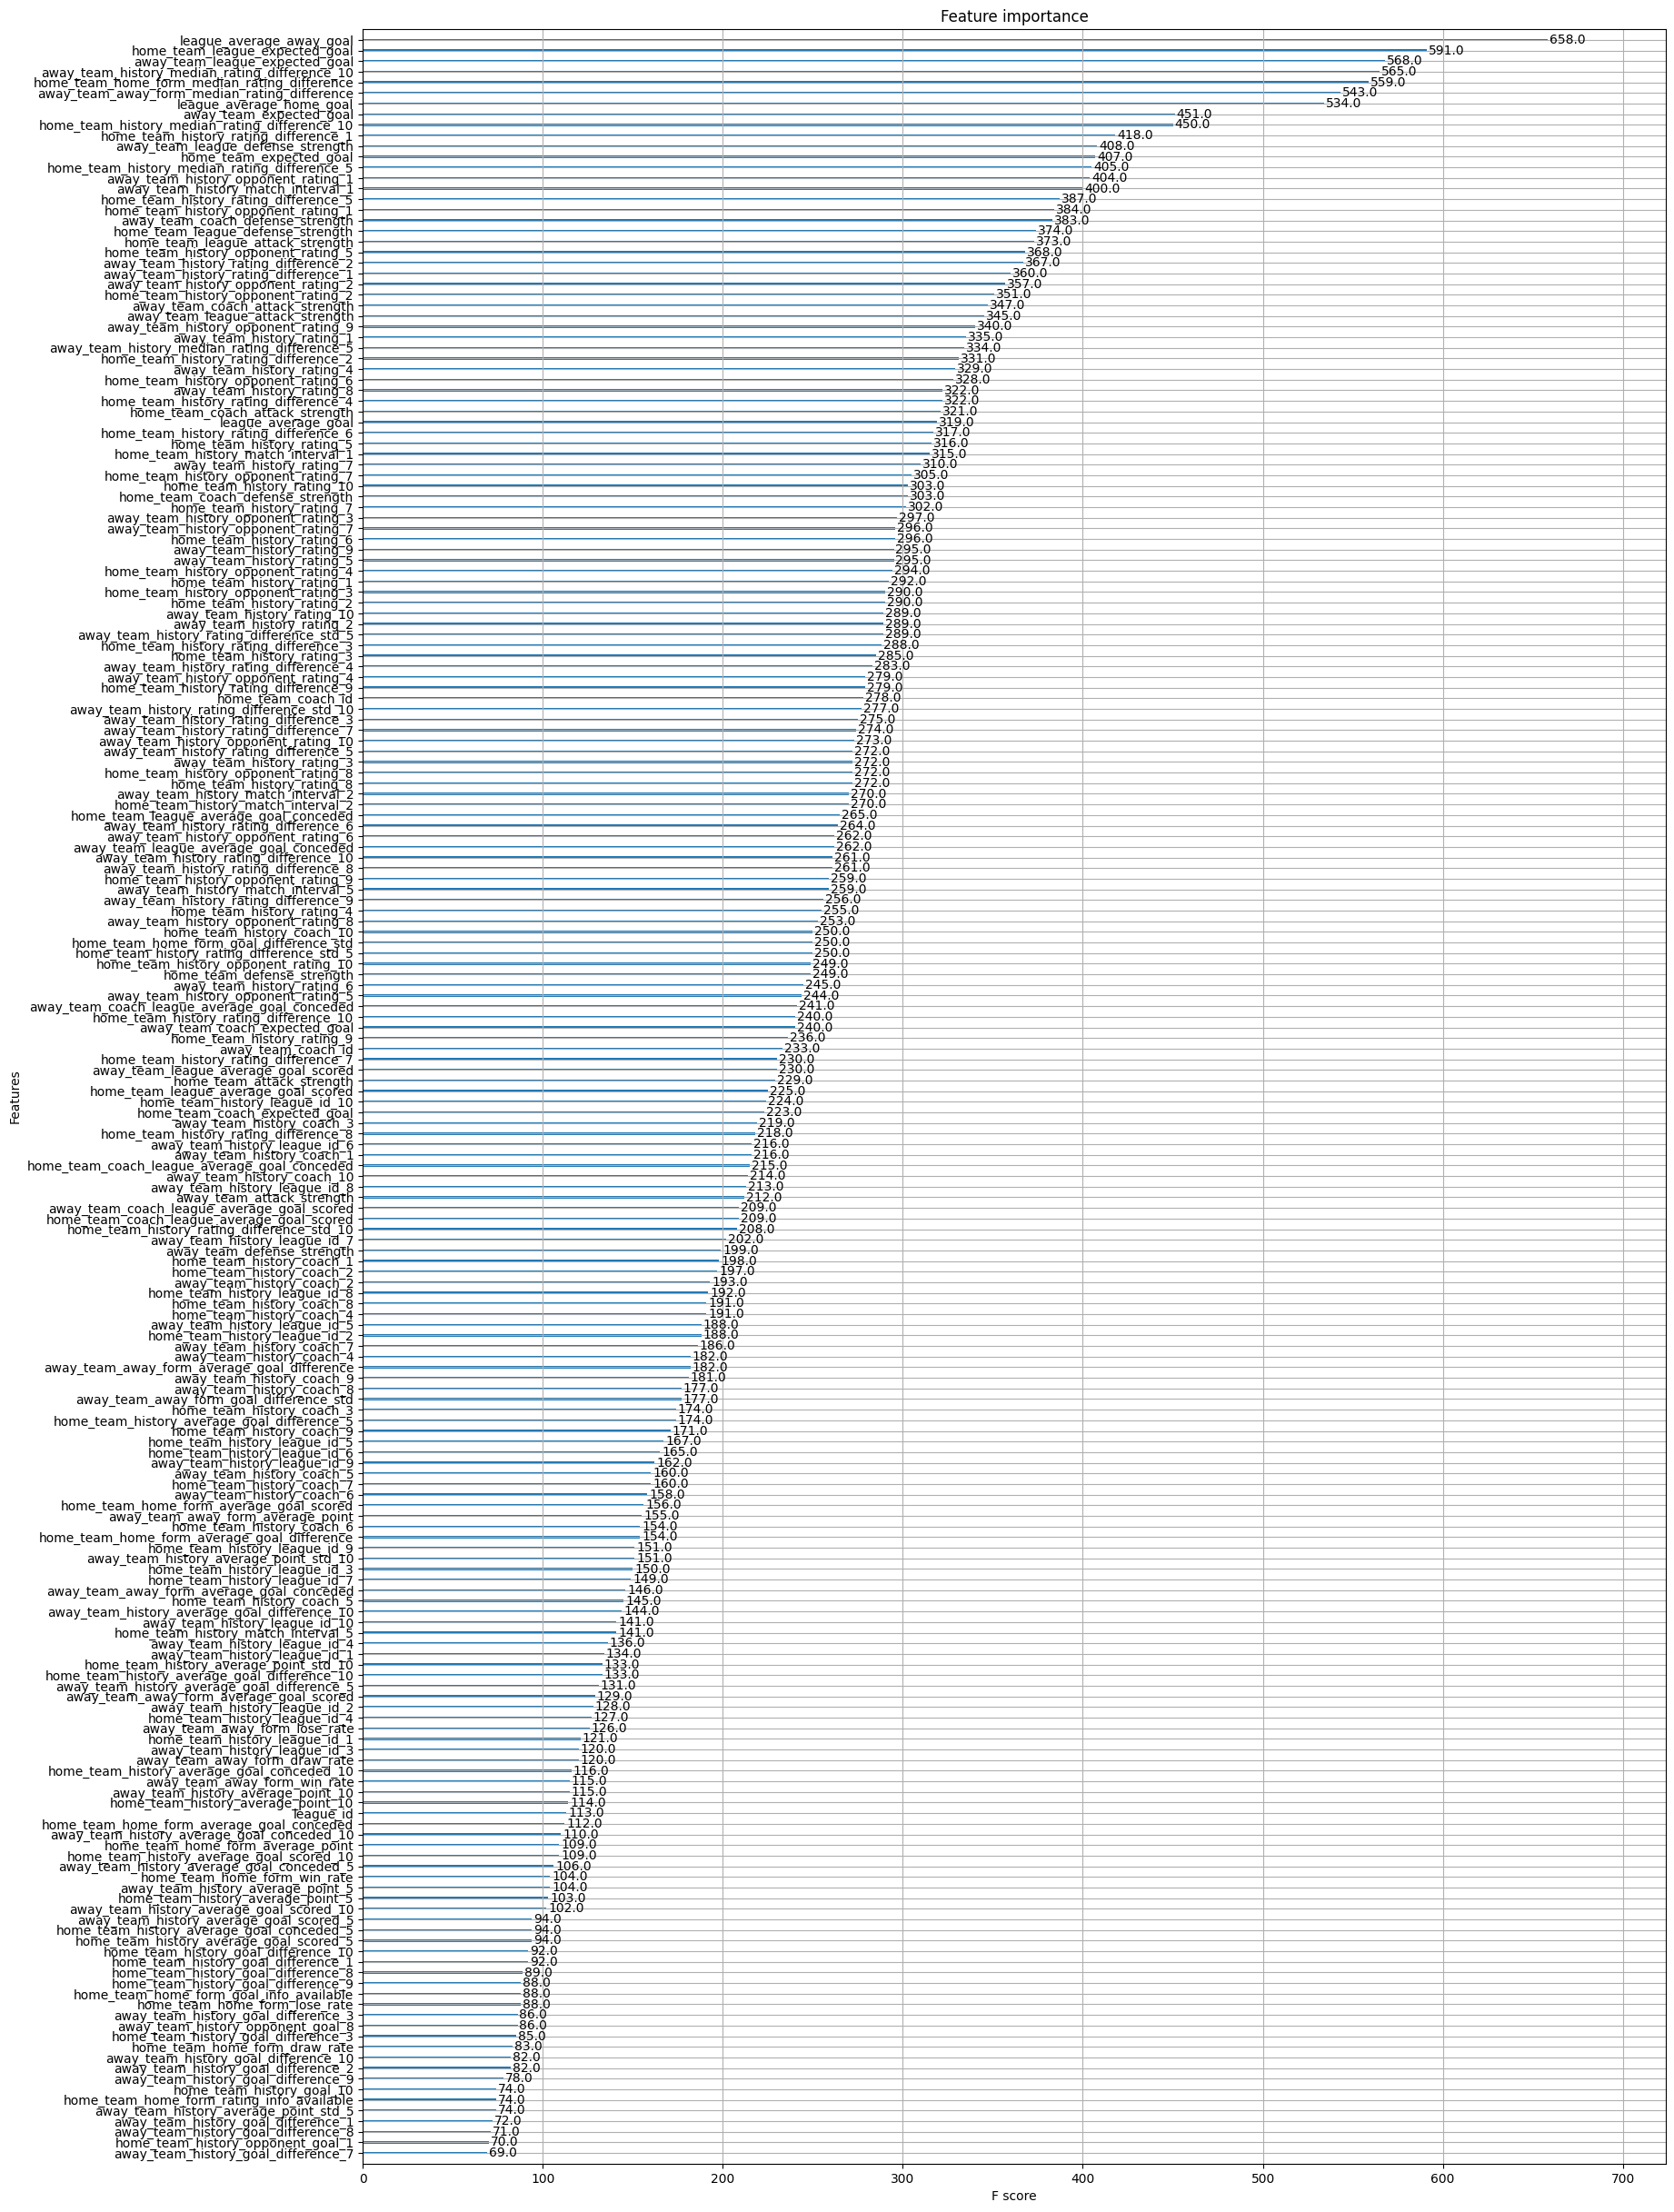

In [21]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

In [22]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
bst.best_iteration

546

In [24]:
bst.best_score

1.0049922525387762

In [25]:
test_p=preprocession(test)

In [26]:
test_p

,id,away_has_coach_change,is_cup,home_team_coach_id,league_id,away_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,11913628,0,1,37570473.0,714,1565666.0,1,8.104167,2.916667,8.104167,...,9.821486,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406
1,11913633,0,1,311388.0,714,1565613.0,1,4.000000,7.041667,4.000000,...,-9.821486,6.103600,-4.627500,-11.938086,-14.805874,-1.642508,NaN,NaN,NaN,NaN
2,11913634,0,1,8055515.0,714,37570473.0,1,3.875000,4.000000,3.875000,...,-21.373595,8.494625,-6.103600,-16.014477,-16.309842,-7.107465,1.642508,6.400896,2.557560,NaN
3,11913635,0,1,1565613.0,714,1565666.0,1,563.208333,66.125000,563.208333,...,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406,-3.105722
4,11913636,0,1,37570473.0,714,311388.0,1,558.020833,529.177083,558.020833,...,5.905686,-5.844033,-4.401500,1.742010,9.223073,16.309842,14.805874,9.010248,9.296814,-0.376575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,18450343,0,1,37346872.0,1393,458369.0,0,4.000000,4.000000,4.000000,...,7.220800,3.931337,5.508441,4.340340,8.816780,8.264750,12.781356,9.703500,10.095828,7.791121
72707,18450597,0,0,NaN,857,NaN,0,4.000000,8.000000,4.000000,...,-0.170433,-1.603467,-1.260983,0.464883,-3.331196,2.390350,3.144440,-1.216000,0.999100,-1.963950
72708,18450602,0,0,NaN,857,37369407.0,0,8.000000,4.000000,8.000000,...,3.375237,6.113917,-0.173000,2.267000,0.027510,0.140788,0.971857,2.816670,6.932963,6.648091
72709,18450640,0,0,524398.0,779,524071.0,0,7.916667,4.687500,7.916667,...,-3.890663,-4.144229,2.553771,2.543150,-2.111475,-2.469550,1.066188,-0.611280,2.151006,-2.486812


In [27]:
X_test=test_p.drop('id', axis=1)
X_test_d = xgb.DMatrix(X_test)

In [28]:
X_test

,away_has_coach_change,is_cup,home_team_coach_id,league_id,away_team_coach_id,home_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,...,away_team_history_rating_difference_1,away_team_history_rating_difference_2,away_team_history_rating_difference_3,away_team_history_rating_difference_4,away_team_history_rating_difference_5,away_team_history_rating_difference_6,away_team_history_rating_difference_7,away_team_history_rating_difference_8,away_team_history_rating_difference_9,away_team_history_rating_difference_10
0,0,1,37570473.0,714,1565666.0,1,8.104167,2.916667,8.104167,2.916667,...,9.821486,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406
1,0,1,311388.0,714,1565613.0,1,4.000000,7.041667,4.000000,7.041667,...,-9.821486,6.103600,-4.627500,-11.938086,-14.805874,-1.642508,NaN,NaN,NaN,NaN
2,0,1,8055515.0,714,37570473.0,1,3.875000,4.000000,3.875000,4.000000,...,-21.373595,8.494625,-6.103600,-16.014477,-16.309842,-7.107465,1.642508,6.400896,2.557560,NaN
3,0,1,1565613.0,714,1565666.0,1,563.208333,66.125000,563.208333,66.125000,...,-8.468983,0.310200,-0.575653,8.201105,-1.742010,16.014477,11.938086,5.109602,-0.571406,-3.105722
4,0,1,37570473.0,714,311388.0,1,558.020833,529.177083,558.020833,529.177083,...,5.905686,-5.844033,-4.401500,1.742010,9.223073,16.309842,14.805874,9.010248,9.296814,-0.376575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,0,1,37346872.0,1393,458369.0,0,4.000000,4.000000,4.000000,4.000000,...,7.220800,3.931337,5.508441,4.340340,8.816780,8.264750,12.781356,9.703500,10.095828,7.791121
72707,0,0,NaN,857,NaN,0,4.000000,8.000000,4.000000,8.000000,...,-0.170433,-1.603467,-1.260983,0.464883,-3.331196,2.390350,3.144440,-1.216000,0.999100,-1.963950
72708,0,0,NaN,857,37369407.0,0,8.000000,4.000000,8.000000,4.000000,...,3.375237,6.113917,-0.173000,2.267000,0.027510,0.140788,0.971857,2.816670,6.932963,6.648091
72709,0,0,524398.0,779,524071.0,0,7.916667,4.687500,7.916667,4.687500,...,-3.890663,-4.144229,2.553771,2.543150,-2.111475,-2.469550,1.066188,-0.611280,2.151006,-2.486812


In [29]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [30]:
predictions

array([[0.70751935, 0.16723582, 0.12524481],
       [0.04463096, 0.06618263, 0.88918644],
       [0.12519188, 0.14600313, 0.728805  ],
       ...,
       [0.3747271 , 0.32316217, 0.30211067],
       [0.18684937, 0.22849199, 0.5846586 ],
       [0.26722538, 0.24137038, 0.49140427]], dtype=float32)

In [31]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test.sort_values(by='id').reset_index()['id']
cols=['id','home','away','draw']
submission=submission[cols]
display(submission)

,id,home,away,draw
0,11913628,0.125245,0.707519,0.167236
1,11913633,0.889186,0.044631,0.066183
2,11913634,0.728805,0.125192,0.146003
3,11913635,0.189833,0.620241,0.189926
4,11913636,0.089466,0.724362,0.186172
...,...,...,...,...
72706,18450343,0.157771,0.618891,0.223338
72707,18450597,0.355284,0.257290,0.387426
72708,18450602,0.302111,0.374727,0.323162
72709,18450640,0.584659,0.186849,0.228492


In [32]:
submission.to_csv('submission.csv', index=False)